<a href="https://colab.research.google.com/github/Fausta-Tata/healthcare-ai-classification-summarization/blob/main/Capstone_Project_Hacktiv_Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install langchain_community
!pip install replicate
!pip install matplotlib seaborn scikit-learn -q

In [41]:
# Setup Library
import pandas as pd
import json
import os
from langchain_community.llms import Replicate
from google.colab import userdata
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [42]:
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

In [43]:
# URL Github Healthcare Dataset

url = 'https://github.com/Fausta-Tata/healthcare-ai-classification-summarization/raw/refs/heads/main/data/HealthcareDocumentationDatabase.csv'


In [44]:
# Set model and model parameters
model = "ibm-granite/granite-3.3-8b-instruct"

parameters = {
  "temperature": 0.1,
  "top_p": 0.75,
  "max_tokens": 70,
  "repetition_penalty": 1.5,

}

In [45]:
llm = Replicate(
    model = model,
    replicate_api_token=api_token,
    model_kwargs = parameters
)

In [46]:
def analyze_transcription(transcription: str, specialty_list: str):
    prompt = f"""
    You are an expert medical assistant. Analyze the following medical transcription.

    Transcription:
    ---
    {transcription}
    ---

    Tasks:
    1. Generate a very concise "description" (maximum 20 word in clinical note style) summarizing the patient's condition.
    2. Identify the most relevant "medical_specialty". You MUST select exactly ONE specialty from this list: {specialty_list}

    Output:
    Return the result strictly in valid JSON format, like:

    {{
      "description": "...",
      "medical_specialty": "..."
    }}
    """

    try:
        # Invoke the model
        response = llm.invoke(prompt, parameters=parameters)

        # Cleaner and more robust JSON parsing
        start_index = response.find('{')
        end_index = response.rfind('}') + 1
        if start_index == -1 or end_index == 0:
            raise json.JSONDecodeError("No JSON object found in the response.", response, 0)

        json_str = response[start_index:end_index]
        json_response = json.loads(json_str)

        return {
            "description": json_response.get("description", "N/A"),
            "medical_specialty": json_response.get("medical_specialty", "N/A")
        }
    except json.JSONDecodeError as e:
        print(f"\nFailed to parse JSON. Error: {e}")
        return None
    except Exception as e:
        print(f"\nError: {e}")
        return None

In [47]:
def main():
    try:
        # Import Healthcare Dataset
        df = pd.read_csv(url)
        # Drop Null Values
        df.dropna(subset=['transcription', 'medical_specialty', 'description'], inplace=True)
    except Exception as e:
        print(f"Error: {e}")
        return

    # Create a Unique List of Medical Specialties for The Models to Choose From.
    unique_specialties = df['medical_specialty'].unique().tolist()
    specialty_list_str = ", ".join(f"'{s.strip()}'" for s in unique_specialties)

    # Taking Random Data Samples
    sample_size = 5
    sample_df = df.sample(n=sample_size, random_state=27)


    # Create Variable for Accuration Process
    total_sampel = 0
    prediksi_benar = 0

    # Create Lists to Store Results for Visualization
    actual_labels = []
    predicted_labels = []

    # Analysis Process
    for index, row in sample_df.iterrows():
        print(f"\n---------------- Analisis Data #{index + 1} ----------------")
        original_transcription = row['transcription']
        original_specialty = row['medical_specialty'].strip()
        original_description = row['description'].strip()

        # Call Function AI
        ai_result = analyze_transcription(original_transcription, specialty_list_str)

        if ai_result:
            total_sampel += 1
            ai_specialty = ai_result['medical_specialty'].strip()
            ai_description = ai_result['description'].strip()

            actual_labels.append(original_specialty)
            predicted_labels.append(ai_specialty)

            print("\n--- Perbandingan Deskripsi ---")
            print(f"Deskripsi Asli: {textwrap.fill(original_description, width=100)}")
            print(f"\nDeskripsi AI  : {textwrap.fill(ai_description, width=100)}")

            print("\n\n--- Perbandingan Spesialisasi Medis ---")
            print(f"Spesialisasi Asli: {original_specialty}")
            print(f"Spesialisasi AI  : {ai_specialty}")

            # Logic of comparison of AI Results and Original Data
            if original_specialty.lower() in ai_specialty.lower():
                prediksi_benar += 1
                print("Status           : Akurat")
            else:
                print("Status           : Tidak Akurat")


   # Final Accuracy Result
    if total_sampel > 0:
        akurasi = (prediksi_benar / total_sampel) * 100
        print(f"\n\n------ HASIL ANALISIS KESELURUHAN ------")
        print(f"Total Sampel Dianalisis: {total_sampel}")
        print(f"Jumlah Prediksi Benar  : {prediksi_benar}")
        print(f"Tingkat Akurasi Model  : {akurasi:.2f}%")

        # Create and display the visualization from the collected results
        if len(actual_labels) > 0:
            labels = sorted(unique_labels(actual_labels, predicted_labels))
            cm = confusion_matrix(actual_labels, predicted_labels, labels=labels)

            plt.figure(figsize=(12, 10))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

            plt.title('Confusion Matrix: AI Prediction vs. Actual Label', fontsize=16)
            plt.ylabel('Actual Label', fontsize=12)
            plt.xlabel('Predicted Label', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()

            plt.savefig('confusion_matrix.png', dpi=300)
            plt.show()

    else:
        print("\nTidak ada sampel yang berhasil dianalisis.")


---------------- Analisis Data #1824 ----------------

--- Perbandingan Deskripsi ---
Deskripsi Asli: A 19-year-old right-handed male injured in a motor vehicle accident.

Deskripsi AI  : 19yo male post-MVA with cervical/lumbar radiculopathy, disc herniations, myofascitis, scheduled for
EMG study.


--- Perbandingan Spesialisasi Medis ---
Spesialisasi Asli: Orthopedic
Spesialisasi AI  : Neurosurgery
Status           : Tidak Akurat

---------------- Analisis Data #501 ----------------

--- Perbandingan Deskripsi ---
Deskripsi Asli: Right middle ear exploration with a Goldenberg TORP reconstruction.

Deskripsi AI  : Profound mixed sensorineural conductive hearing loss, otosclerosis, stapes fixation, no round window
niche, revision surgery.


--- Perbandingan Spesialisasi Medis ---
Spesialisasi Asli: Surgery
Spesialisasi AI  : Otolaryngology
Status           : Tidak Akurat

---------------- Analisis Data #177 ----------------

--- Perbandingan Deskripsi ---
Deskripsi Asli: Fertile male w

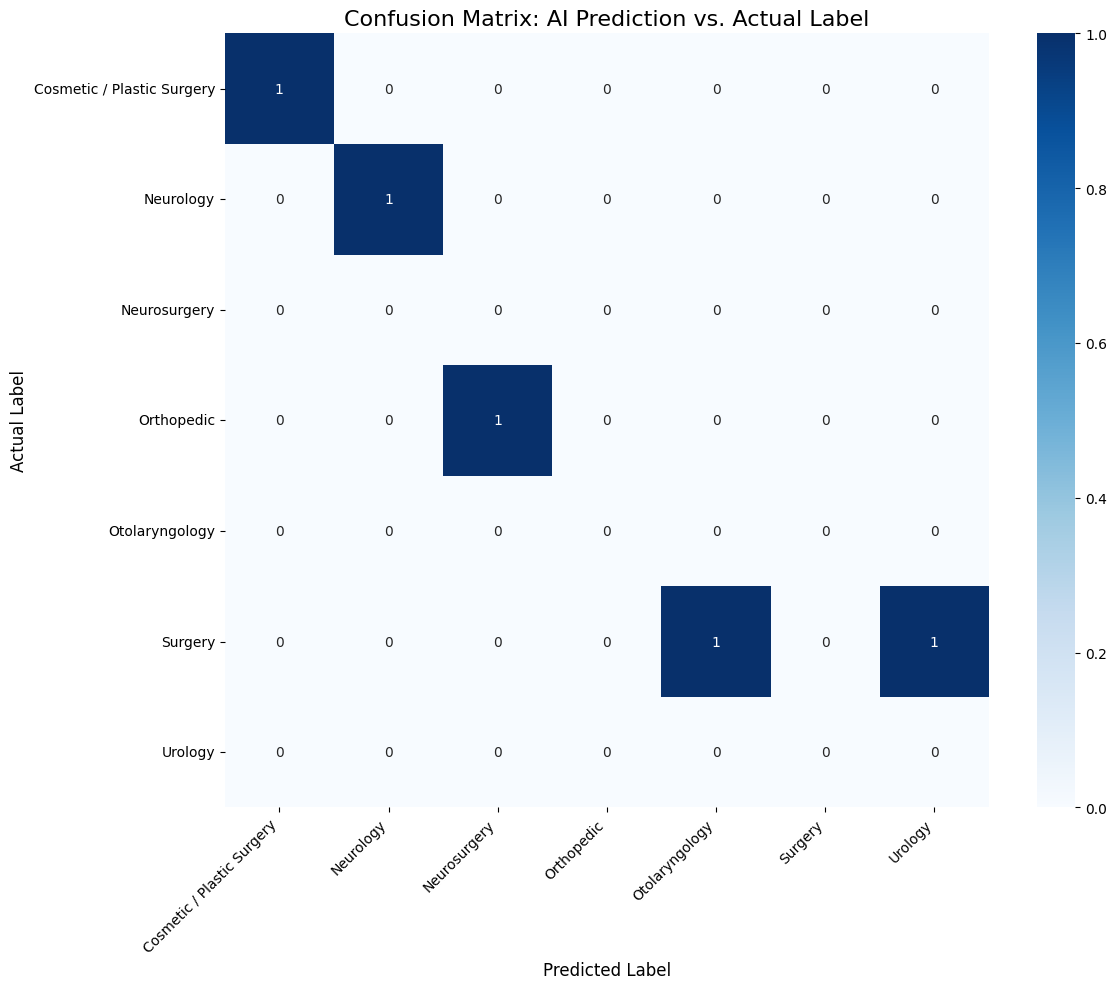

In [48]:
# Run The Program
if __name__ == "__main__":
    main()